# Import

In [1]:
import os
import json
from collections import OrderedDict, defaultdict

In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from mmseg.registry import DATASETS, TRANSFORMS, MODELS, METRICS
from mmseg.datasets import BaseSegDataset
from mmseg.models.segmentors import EncoderDecoder
from mmseg.models.decode_heads import ASPPHead, FCNHead, SegformerHead
from mmseg.models.utils.wrappers import resize


from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner, load_checkpoint
from mmengine.evaluator import BaseMetric
from mmengine.logging import MMLogger, print_log
from mmengine.structures import PixelData

from mmcv.transforms import BaseTransform

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM/"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json/"

In [5]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [6]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [7]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [8]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [9]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# MixIn Classes

In [10]:
class PostProcessResultMixin:
    def postprocess_result(self,
                           seg_logits,
                           data_samples):
        """ Convert results list to `SegDataSample`.
        Args:
            seg_logits (Tensor): The segmentation results, seg_logits from
                model of each input image.
            data_samples (list[:obj:`SegDataSample`]): The seg data samples.
                It usually includes information such as `metainfo` and
                `gt_sem_seg`. Default to None.
        Returns:
            list[:obj:`SegDataSample`]: Segmentation results of the
            input images. Each SegDataSample usually contain:

            - ``pred_sem_seg``(PixelData): Prediction of semantic segmentation.
            - ``seg_logits``(PixelData): Predicted logits of semantic
                segmentation before normalization.
        """
        batch_size, C, H, W = seg_logits.shape

        if data_samples is None:
            data_samples = [SegDataSample() for _ in range(batch_size)]
            only_prediction = True
        else:
            only_prediction = False

        for i in range(batch_size):
            if not only_prediction:
                img_meta = data_samples[i].metainfo
                # remove padding area
                if 'img_padding_size' not in img_meta:
                    padding_size = img_meta.get('padding_size', [0] * 4)
                else:
                    padding_size = img_meta['img_padding_size']
                padding_left, padding_right, padding_top, padding_bottom =\
                    padding_size
                # i_seg_logits shape is 1, C, H, W after remove padding
                i_seg_logits = seg_logits[i:i + 1, :,
                                          padding_top:H - padding_bottom,
                                          padding_left:W - padding_right]

                flip = img_meta.get('flip', None)
                if flip:
                    flip_direction = img_meta.get('flip_direction', None)
                    assert flip_direction in ['horizontal', 'vertical']
                    if flip_direction == 'horizontal':
                        i_seg_logits = i_seg_logits.flip(dims=(3, ))
                    else:
                        i_seg_logits = i_seg_logits.flip(dims=(2, ))

                # resize as original shape
                i_seg_logits = resize(
                    i_seg_logits,
                    size=img_meta['ori_shape'],
                    mode='bilinear',
                    align_corners=self.align_corners,
                    warning=False).squeeze(0)
            else:
                i_seg_logits = seg_logits[i]

            i_seg_logits = i_seg_logits.sigmoid()
            i_seg_pred = (i_seg_logits > 0.5).to(i_seg_logits)

            data_samples[i].set_data({
                'seg_logits':
                PixelData(**{'data': i_seg_logits}),
                'pred_sem_seg':
                PixelData(**{'data': i_seg_pred})
            })

        return data_samples

In [11]:
@MODELS.register_module()
class EncoderDecoderWithoutArgmax(PostProcessResultMixin, EncoderDecoder):
    pass

In [12]:
class LossByFeatMixIn:
    def loss_by_feat(self, seg_logits, batch_data_samples) -> dict:
        """Compute segmentation loss.

        Args:
            seg_logits (Tensor): The output from decode head forward function.
            batch_data_samples (List[:obj:`SegDataSample`]): The seg
                data samples. It usually includes information such
                as `metainfo` and `gt_sem_seg`.

        Returns:
            dict[str, Tensor]: a dictionary of loss components
        """

        seg_label = self._stack_batch_gt(batch_data_samples)
        loss = dict()
        seg_logits = resize(
            input=seg_logits,
            size=seg_label.shape[2:],
            mode='bilinear',
            align_corners=self.align_corners)
        if self.sampler is not None:
            seg_weight = self.sampler.sample(seg_logits, seg_label)
        else:
            seg_weight = None

        if not isinstance(self.loss_decode, nn.ModuleList):
            losses_decode = [self.loss_decode]
        else:
            losses_decode = self.loss_decode
        for loss_decode in losses_decode:
            if loss_decode.loss_name not in loss:
                loss[loss_decode.loss_name] = loss_decode(
                    seg_logits,
                    seg_label,
                    weight=seg_weight,
                    ignore_index=self.ignore_index)
            else:
                loss[loss_decode.loss_name] += loss_decode(
                    seg_logits,
                    seg_label,
                    weight=seg_weight,
                    ignore_index=self.ignore_index)

        return loss

In [13]:
@MODELS.register_module()
class ASPPHeadWithoutAccuracy(LossByFeatMixIn, ASPPHead):
    pass

In [14]:
@MODELS.register_module()
class FCNHeadWithoutAccuracy(LossByFeatMixIn, FCNHead):
    pass

In [15]:
@MODELS.register_module()
class SegformerHeadWithoutAccuracy(LossByFeatMixIn, SegformerHead):
    pass

# Dataset

In [16]:
@DATASETS.register_module()
class XRayDataset(BaseSegDataset):
    def __init__(self, is_train, **kwargs):
        self.is_train = is_train

        super().__init__(**kwargs)

    def load_data_list(self):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)

        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]

        # dummy label
        ys = [0 for fname in _filenames]

        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)

        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if self.is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue

                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])

            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])

                # skip i > 0
                break

        data_list = []
        for i, (img_path, ann_path) in enumerate(zip(filenames, labelnames)):
            data_info = dict(
                img_path=os.path.join(IMAGE_ROOT, img_path),
                seg_map_path=os.path.join(LABEL_ROOT, ann_path),
            )
            data_list.append(data_info)

        return data_list

In [17]:
@TRANSFORMS.register_module()
class LoadXRayAnnotations(BaseTransform):
    def transform(self, result):
        label_path = result["seg_map_path"]

        image_size = (2048, 2048)

        # process a label of shape (H, W, NC)
        label_shape = image_size + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon to mask
            class_label = np.zeros(image_size, dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        result["gt_seg_map"] = label

        return result

In [18]:
@TRANSFORMS.register_module()
class TransposeAnnotations(BaseTransform):
    def transform(self, result):
        result["gt_seg_map"] = np.transpose(result["gt_seg_map"], (2, 0, 1))

        return result

# Metric

In [19]:
@METRICS.register_module()
class DiceMetric(BaseMetric):
    def __init__(self,
                 collect_device='cpu',
                 prefix=None,
                 **kwargs):
        super().__init__(collect_device=collect_device, prefix=prefix)

    @staticmethod
    def dice_coef(y_true, y_pred):
        y_true_f = y_true.flatten(-2)
        y_pred_f = y_pred.flatten(-2)
        intersection = torch.sum(y_true_f * y_pred_f, -1)

        eps = 0.0001
        return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

    def process(self, data_batch, data_samples):
        """Process one batch of data and data_samples.

        The processed results should be stored in ``self.results``, which will
        be used to compute the metrics when all batches have been processed.

        Args:
            data_batch (dict): A batch of data from the dataloader.
            data_samples (Sequence[dict]): A batch of outputs from the model.
        """
        for data_sample in data_samples:
            pred_label = data_sample['pred_sem_seg']['data']

            label = data_sample['gt_sem_seg']['data'].to(pred_label)
            self.results.append(
                self.dice_coef(label, pred_label)
            )

    def compute_metrics(self, results):
        """Compute the metrics from processed results.

        Args:
            results (list): The processed results of each batch.

        Returns:
            Dict[str, float]: The computed metrics. The keys are the names of
                the metrics, and the values are corresponding results.
        """
        logger: MMLogger = MMLogger.get_current_instance()

        results = torch.stack(self.results, 0)
        dices_per_class = torch.mean(results, 0)
        avg_dice = torch.mean(dices_per_class)

        ret_metrics = {
            "Dice": dices_per_class.detach().cpu().numpy(),
        }
        # summary table
        ret_metrics_summary = OrderedDict({
            ret_metric: np.round(np.nanmean(ret_metric_value) * 100, 2)
            for ret_metric, ret_metric_value in ret_metrics.items()
        })

        metrics = {
            "mDice": torch.mean(dices_per_class).item()
        }

        # each class table
        ret_metrics.pop('aAcc', None)
        ret_metrics_class = OrderedDict({
            ret_metric: np.round(ret_metric_value * 100, 2)
            for ret_metric, ret_metric_value in ret_metrics.items()
        })
        ret_metrics_class.update({'Class': CLASSES})
        ret_metrics_class.move_to_end('Class', last=False)
        class_table_data = PrettyTable()
        for key, val in ret_metrics_class.items():
            class_table_data.add_column(key, val)

        print_log('per class results:', logger)
        print_log('\n' + class_table_data.get_string(), logger=logger)

        return metrics

# Configs

In [20]:
%%writefile dataset_setting.py

# dataset settings
dataset_type = 'XRayDataset'
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadXRayAnnotations'),
    dict(type='Resize', scale=(512, 512)),
    dict(type='TransposeAnnotations'),
    dict(type='PackSegInputs')
]
val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512)),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadXRayAnnotations'),
    dict(type='TransposeAnnotations'),
    dict(type='PackSegInputs')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512)),
    dict(type='PackSegInputs')
]

train_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='InfiniteSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        is_train=True,
        pipeline=train_pipeline
    )
)
val_dataloader = dict(
    batch_size=1,
    num_workers=0,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        is_train=False,
        pipeline=val_pipeline
    )
)
test_dataloader = val_dataloader

val_evaluator = dict(type='DiceMetric')
test_evaluator = val_evaluator

Overwriting dataset_setting.py


In [21]:
%%writefile config_for_this_example.py

# Train Segformer Mit B3
_base_ = [
    "mmsegmentation/configs/_base_/models/segformer_mit-b0.py",
    "dataset_setting.py",
    "mmsegmentation/configs/_base_/default_runtime.py"
]

data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[0., 0., 0.],
    std=[255., 255., 255.],
    bgr_to_rgb=True,
    size=(512, 512),
    pad_val=0,
    seg_pad_val=255,
)

checkpoint="https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b3_20220624-13b1141c.pth"
model = dict(
    type='EncoderDecoderWithoutArgmax',
    data_preprocessor=data_preprocessor,
    backbone=dict(
        init_cfg=dict(type='Pretrained', checkpoint=checkpoint),
        embed_dims=64,
        num_heads=[1, 2, 5, 8],
        num_layers=[3, 4, 18, 3]),
    decode_head=dict(
        type='SegformerHeadWithoutAccuracy',
        in_channels=[64, 128, 320, 512],
        num_classes=29,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=True,
            loss_weight=1.0,
        ),
    ),
)

# optimizer
optimizer = dict(type='AdamW', lr=0.00006, betas=(0.9, 0.999), weight_decay=0.01)
optim_wrapper = dict(type='OptimWrapper', optimizer=optimizer, clip_grad=None)

# mixed precision
fp16 = dict(loss_scale='dynamic')

# learning policy
param_scheduler = [
    dict(
        type='LinearLR', start_factor=1e-6, by_epoch=False, begin=0, end=1500
    ),
    dict(
        type='PolyLR',
        eta_min=0.0,
        power=1.0,
        begin=1500,
        end=20000,
        by_epoch=False,
    )
]
# training schedule for 20k
train_cfg = dict(type='IterBasedTrainLoop', max_iters=20000, val_interval=2000)
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')
default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50, log_metric_by_epoch=False),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=2000),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='SegVisualizationHook')
)

Overwriting config_for_this_example.py


# Train

In [22]:
# load config
cfg = Config.fromfile("./config_for_this_example.py")
cfg.launcher = "none"
cfg.work_dir = "baseline2"

# resume training
cfg.resume = False

In [24]:
runner = Runner.from_cfg(cfg)

# start training
runner.train()

11/21 15:07:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 666646582
    GPU 0: Tesla V100-SXM2-32GB
    CUDA_HOME: /usr
    NVCC: Cuda compilation tools, release 10.1, V10.1.24
    GCC: n/a
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_

/bin/sh: 1: gcc: not found


11/21 15:07:16 - mmengine - INFO - Config:
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b3_20220624-13b1141c.pth'
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        0.0,
        0.0,
        0.0,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        255.0,
        255.0,
        255.0,
    ],
    type='SegDataPreProcessor')
dataset_type = 'XRayDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=2000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
fp16

/opt/conda/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


11/21 15:07:16 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
11/21 15:07:16 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/data/ephemeral/home/mpark/level2-cv-semanticsegmentation-cv-8-lv3/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/data/ephemeral/home/mpark/level2-cv-semanticsegmentation-cv-8-lv3/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


11/21 15:07:17 - mmengine - WARNING - The prefix is not set in metric class DiceMetric.


/data/ephemeral/home/mpark/level2-cv-semanticsegmentation-cv-8-lv3/mmsegmentation/mmseg/datasets/transforms/formatting.py:81: UserWarning: Please pay attention your ground truth segmentation map, usually the segmentation map is 2D, but got (29, 2048, 2048)
  warnings.warn('Please pay attention your ground truth '
/data/ephemeral/home/mpark/level2-cv-semanticsegmentation-cv-8-lv3/mmsegmentation/mmseg/datasets/transforms/formatting.py:81: UserWarning: Please pay attention your ground truth segmentation map, usually the segmentation map is 2D, but got (29, 2048, 2048)
  warnings.warn('Please pay attention your ground truth '


11/21 15:07:18 - mmengine - INFO - load model from: https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b3_20220624-13b1141c.pth
11/21 15:07:18 - mmengine - INFO - Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b3_20220624-13b1141c.pth
11/21 15:07:18 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
11/21 15:07:18 - mmengine - INFO - Checkpoints will be saved to /data/ephemeral/home/mpark/level2-cv-semanticsegmentation-cv-8-lv3/baseline2.
11/21 15:07:51 - mmengine - INFO - Iter(train) [   50/20000]  lr: 1.9614e-06  eta: 3:39:47  time: 0.6085  data_time: 0.1909  memory: 9906  loss: 0.6928  decode.loss_ce: 0.6928


KeyboardInterrupt: 

# Result visualization

In [ ]:
model = MODELS.build(cfg.model)

In [ ]:
checkpoint = load_checkpoint(
    model,
    "baseline2/iter_20000.pth",
    map_location='cpu'
)

In [ ]:
def _preprare_data(imgs, model):
    for t in cfg.test_pipeline:
        if t.get('type') in ['LoadXRayAnnotations', 'TransposeAnnotations']:
            cfg.test_pipeline.remove(t)

    is_batch = True
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
        is_batch = False

    if isinstance(imgs[0], np.ndarray):
        cfg.test_pipeline[0]['type'] = 'LoadImageFromNDArray'

    # TODO: Consider using the singleton pattern to avoid building
    # a pipeline for each inference
    pipeline = Compose(cfg.test_pipeline)

    data = defaultdict(list)
    for img in imgs:
        if isinstance(img, np.ndarray):
            data_ = dict(img=img)
        else:
            data_ = dict(img_path=img)
        data_ = pipeline(data_)
        data['inputs'].append(data_['inputs'])
        data['data_samples'].append(data_['data_samples'])

    return data, is_batch

In [ ]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

In [ ]:
img = cv2.imread(os.path.join(IMAGE_ROOT, "ID001", "image1661130828152_R.png"))

In [ ]:
# prepare data
data, is_batch = _preprare_data(img, model)

# forward the model
with torch.no_grad():
    results = model.test_step(data)

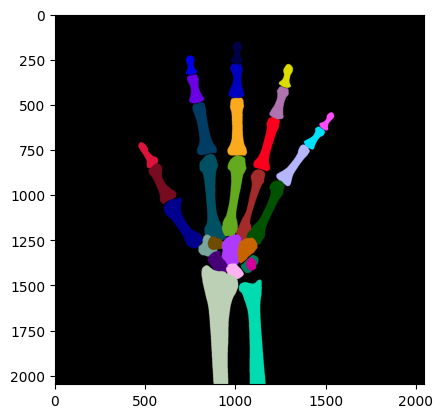

In [ ]:
plt.imshow(label2rgb(results[0].pred_sem_seg.data))

# Inference

In [ ]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/data/test/DCM/"

In [24]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [25]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(height, width)

In [27]:
def test(model, image_paths, thr=0.5):
    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
            img = cv2.imread(os.path.join(IMAGE_ROOT,image_path))

            # prepare data
            data, is_batch = _preprare_data(img, model)

            # forward the model
            with torch.no_grad():
                outputs = model.test_step(data)

            outputs = outputs[0].pred_sem_seg.data
            outputs = outputs[None]

            # restore original size
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()

            output = outputs[0]
            image_name = os.path.basename(image_path)
            for c, segm in enumerate(output):
                rle = encode_mask_to_rle(segm)
                rles.append(rle)
                filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

    return rles, filename_and_class

In [28]:
rles, filename_and_class = test(model, pngs)

NameError: name 'model' is not defined

In [29]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

NameError: name 'filename_and_class' is not defined

In [30]:
df = pd.DataFrame({
    "image_name": filename,
    "class": classes,
    "rle": rles,
})

NameError: name 'filename' is not defined

In [31]:
len(df)

NameError: name 'df' is not defined

In [32]:
df.tail(30)

NameError: name 'df' is not defined

In [ ]:
df.to_csv("submission.csv", index=False)